# Utility Bill through the lens of Climate

---
Author: Daeyoung Kim, Ellen Sun \
Date: 2023-03-30

## Introduction

For our Software Design midterm project, we decided to analyze the patterns in the giant excel sheet of utility bill of Olin through the lens of our local climate. The excel sheet contained the electricity bill from FY01 to November of FY23 with variety of information like date, total electricity consumption, time of peak demand, supply cost, demand-response, and many more. 
<p align="center">
    <img src="images/excel_sheet.png" height="500" alt="Olin's electricity bill excel sheet" />
</p>

Our central research question was:
>How does the variation in Boston climate affect Olin College’s electricity consumption and costs?

## Tidying the Utility Data

To make our dataset useful for analysis, we need to first *tidy* the data. 

Currently, the spreadsheet has rows as variables and columns as observation. The observations are also spread across different tabs by their fiscal year. There are empty rows in the sheet as well as non-uniform nomenclature. The format of values are not standarized and vary across cells within the rows. Thus, the data right now is not very useful to us.  

There are 3 rules to tidy data:
>1. Every column is a variable.
>2. Every row is an observation.
>3. Every cell is a single value.

[Source](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html)

We processed the dataset to adhere to the 3 rules for convenient analysis. 

Below is the code to autoreload cells for our own convenience.

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from os import path
from functions_manage_data import tidy_data
if path.isfile("data/electricity_FY13_23.csv"):
    print("The utility data is ready!")
else:
    tidy_data("data/FY23_Electric_Data_Campus_Houses_edited.xlsx")

The utility data is ready!


Here's a sample of how it looked after processing:

In [41]:
import pandas as pd
from IPython.display import HTML

df_electric_long = pd.read_csv("data/electricity_FY13_23_jittered.csv")
display(HTML(df_electric_long.head(10).to_html()))

,start_read_date,end_read_date,total_consumption,time_of_peak_demand,total_cost
0,2013-04-05 00:00:00,2013-05-06 00:00:00,336786.600122,13:13:00,59485.833176
1,2013-05-06 00:00:00,2013-06-05 00:00:00,318005.869266,14:50:00,51180.789351
2,2013-06-05 00:00:00,2013-07-07 00:00:00,402393.524846,14:20:00,65616.360170
3,2013-07-07 00:00:00,2013-08-05 00:00:00,363047.396729,11:44:00,64522.395080
4,2013-08-05 00:00:00,2013-09-03 00:00:00,358810.854163,12:12:00,43332.149032
5,2013-09-03 00:00:00,2013-10-03 00:00:00,441445.028904,14:35:00,57594.146486
6,2013-10-03 00:00:00,2013-11-04 00:00:00,395707.922060,13:50:00,35046.721204
7,2013-11-04 00:00:00,2013-12-05 00:00:00,285225.674795,10:33:00,40164.581877
8,2013-12-05 00:00:00,2014-01-06 00:00:00,287767.754606,15:55:00,46304.327099
9,2014-01-06 00:00:00,2014-02-04 00:00:00,238868.631300,14:50:00,63663.681731


## Gathering Climate Data
In order to answer our research question, we used the publicly available National Centers for Environmental Information's Climate Data Online (CDO) API to gather Boston's climate data. We chose Boston as our source of 'local' climate since it was geographically proximal to Olin College and had the most comprehensive data because of Boston Logan Airport's stable data collection. 

The employed steps in gathering data from the API were:
1. Find the Massachusetts ID used in the API
2. Find weather stations in MA
3. Choose a station and find available datatypes
4. Choose relevant datatypes and fetch data
5. Save into a .json and pandas dataframe

In [42]:
import requests

FIPS_URL = "https://www.ncei.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=ST&limit=52"

with open("API_KEY.txt", "r", encoding="utf-8") as file:
    token = file.read()

response = requests.get(FIPS_URL, headers={"token": token})
print(response.json()["results"][21])

{'mindate': '1831-02-01', 'maxdate': '2023-03-29', 'name': 'Massachusetts', 'datacoverage': 1, 'id': 'FIPS:25'}


Now, using `FIPS:25` as ID for Massachusetts, we found all the available stations. We found the ID (`GHCND:USW00014739`) for the Boston Logan weather station, which was the station that had the most coverage and would work best for our needs.

In [43]:
import json

STATION_URL = (
    "https://www.ncei.noaa.gov/cdo-web/api/v2/stations/GHCND:USW00014739"
)

response = requests.get(STATION_URL, headers={"token": token})
boston_logan_airport = json.dumps(response.json(), indent=4)
print(boston_logan_airport)

{
    "elevation": 3.2,
    "mindate": "1936-01-01",
    "maxdate": "2023-03-27",
    "latitude": 42.36057,
    "name": "BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",
    "datacoverage": 1,
    "id": "GHCND:USW00014739",
    "elevationUnit": "METERS",
    "longitude": -71.00975
}


In [44]:
START_DATE = "2013-04-01"
END_DATE = "2022-12-31"
DATATYPE_URL = "https://www.ncei.noaa.gov/cdo-web/api/v2/datatypes?stationid=GHCND:USW00014739&startdate=2013-04-01&enddate=2022-12-31"
response = requests.get(DATATYPE_URL, headers={"token": token})
df_datatypes = pd.json_normalize(response.json(), record_path=["results"])

Here were some of the available datatypes:

In [45]:
display(HTML(df_datatypes.head(10).to_html()))

,mindate,maxdate,name,datacoverage,id
0,1781-01-01,2016-03-01,Number of days with greater than or equal to 0.5 inch of precipitation,1,DP05
1,1763-01-01,2016-03-01,Number days with maximum temperature greater than or equal 90.0 F,1,DT90
2,1763-01-01,2023-02-01,Day Extreme minimum temperature occurred for the period.,1,DYNT
3,1840-05-01,2023-02-01,Day the extreme maximum daily snowfall for the period occurred.,1,DYSN
4,1781-01-01,2023-02-01,Day Extreme maximum daily precipitation for the period.,1,DYXP
5,1763-01-01,2023-02-01,Date Extreme maximum temperature occurred for the period.,1,DYXT
6,1763-01-01,2022-01-01,First freeze <= to 32F/0C of the year.,1,FZF0
7,1765-01-01,2022-01-01,First freeze <= 28F/-2.2C of the year,1,FZF1
8,1767-01-01,2022-01-01,First freeze <= 24F/-4.4C of the year,1,FZF2
9,1774-01-01,2022-01-01,First freeze <= 20F/-6.7C of the year,1,FZF3


Although our intial approach was using the API for listing the available datatypes, the results were unorganized even with start and end date queries and did not give us the information that we needed. Thus, we found an [online documentation page](https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00014739/detail) of the specific weather station and looked for available datatypes there. 
<p align="center">
    <img src="images/station.png" height="500" alt="Station documentation page" />
</p>

We chose `TAVG`, `AWND`, and `PRCP` for the datatypes and saved them locally as .json files. 

In [46]:
from os import path
from functions_manage_data import get_data_api

DATATYPES = ["TAVG", "PRCP", "AWND"]

for datatype in DATATYPES:
    if path.isfile(f"data/{datatype}.json"):
        print(f"{datatype} dataset is ready!")
    else:
        get_data_api(datatype)

TAVG dataset is ready!
PRCP dataset is ready!
AWND dataset is ready!


After storing the information about each datatype into a `.json` file, we flattened the `.json` files into `pandas` dataframes. Then, we read the utilities data into a pandas dataframe and created a joint dataframe between each weather datatype and the utility information to make it easier to plot. Below is a sample of how the dataframe containing information about the average wind speed looks like. 

In [47]:
from functions_manage_data import flatten_json, join_dataframes

df_avg_temp = flatten_json("TAVG")
df_total_prcp = flatten_json("PRCP")
df_avg_wind = flatten_json("AWND")
df_util = pd.read_csv("./data/electricity_FY13_23_jittered.csv")

df_util_wind = join_dataframes(df_avg_wind, df_util)
df_util_temp = join_dataframes(df_avg_temp, df_util)
df_util_prcp = join_dataframes(df_total_prcp, df_util)

display(HTML(df_util_wind.head(10).to_html()))

,start_read_date,end_read_date,total_consumption,time_of_peak_demand,total_cost,year-month,date,datatype,station,attributes,value
0,2013-04-05,2013-05-06 00:00:00,336786.600122,13:13:00,59485.833176,2013-04,2013-04-01,AWND,GHCND:USW00014739,",W",12.3
1,2013-05-06,2013-06-05 00:00:00,318005.869266,14:50:00,51180.789351,2013-05,2013-05-01,AWND,GHCND:USW00014739,",W",9.6
2,2013-06-05,2013-07-07 00:00:00,402393.524846,14:20:00,65616.360170,2013-06,2013-06-01,AWND,GHCND:USW00014739,",W",10.5
3,2013-07-07,2013-08-05 00:00:00,363047.396729,11:44:00,64522.395080,2013-07,2013-07-01,AWND,GHCND:USW00014739,",W",9.2
4,2013-08-05,2013-09-03 00:00:00,358810.854163,12:12:00,43332.149032,2013-08,2013-08-01,AWND,GHCND:USW00014739,",W",8.9
5,2013-09-03,2013-10-03 00:00:00,441445.028904,14:35:00,57594.146486,2013-09,2013-09-01,AWND,GHCND:USW00014739,",W",8.9
6,2013-10-03,2013-11-04 00:00:00,395707.922060,13:50:00,35046.721204,2013-10,2013-10-01,AWND,GHCND:USW00014739,",W",8.9
7,2013-11-04,2013-12-05 00:00:00,285225.674795,10:33:00,40164.581877,2013-11,2013-11-01,AWND,GHCND:USW00014739,",W",11.6
8,2013-12-05,2014-01-06 00:00:00,287767.754606,15:55:00,46304.327099,2013-12,2013-12-01,AWND,GHCND:USW00014739,",W",10.1
9,2014-01-06,2014-02-04 00:00:00,238868.631300,14:50:00,63663.681731,2014-01,2014-01-01,AWND,GHCND:USW00014739,",W",11.9


The joint dataframes contain columns detailing utility information (`total_consumption`, `time_of_peak_demand`, `total_cost`) and weather information (`datatype`, showing which category this data is from, and `value`, showing the actual value taken-- in the displayed case, the average monthly wind speed in MPH)

Now we can plot each weather datatype against the `total monthly electricity consumption` (kwh) of Olin.  

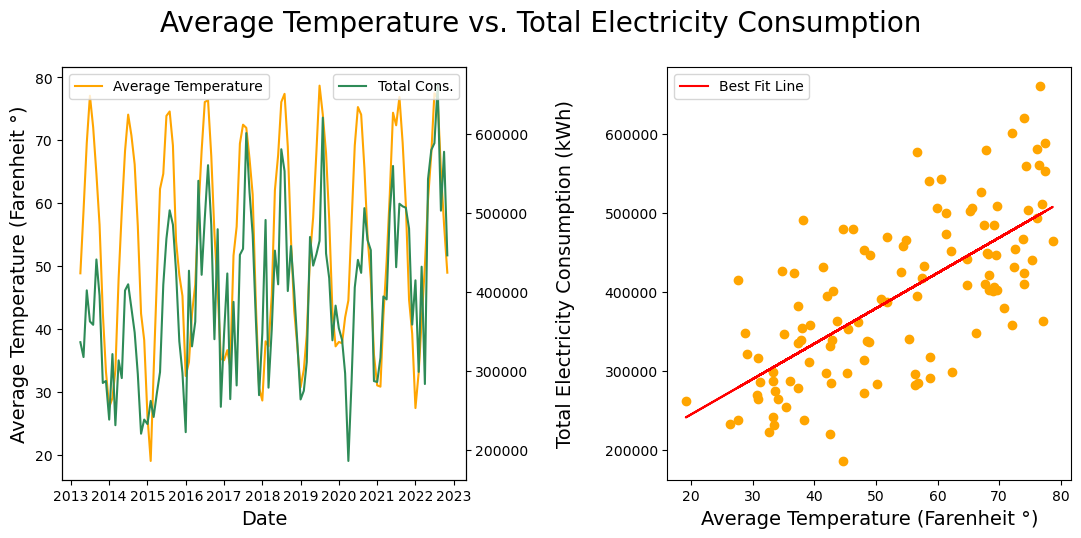

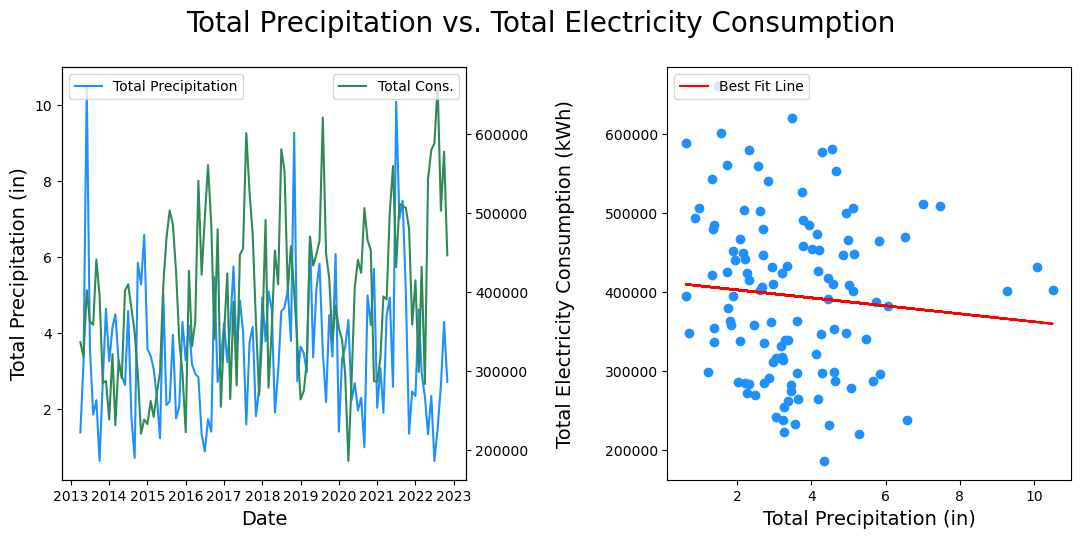

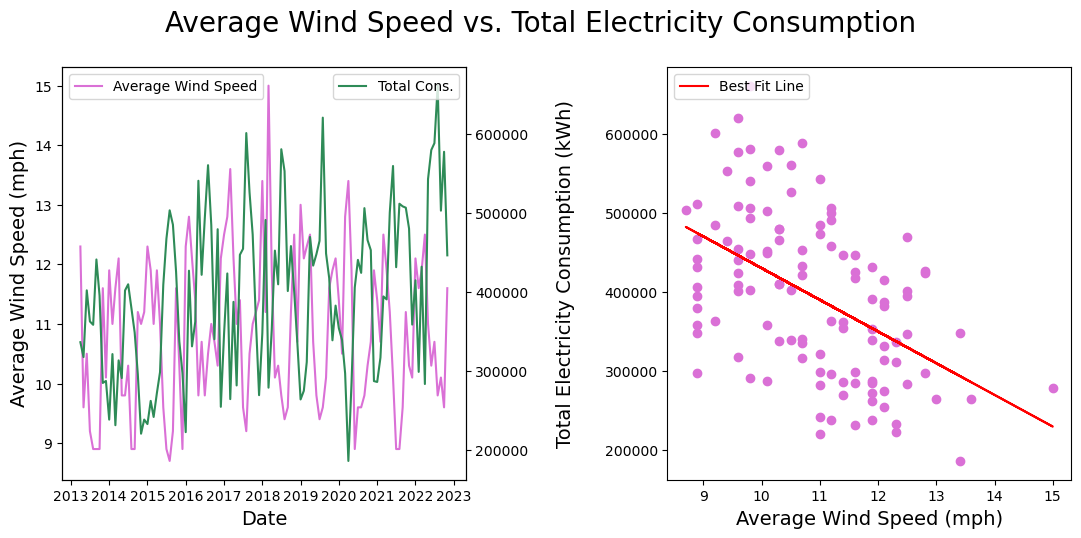

In [48]:
from functions_plot_data import plot_weather_util_2_plots

plot_weather_util_2_plots(df_util_temp)
plot_weather_util_2_plots(df_util_prcp)
plot_weather_util_2_plots(df_util_wind)

Next, we put each specific r-value in a table to see the exact correlations between each of the weather datatypes and total monthly electricity consumption:

In [49]:
from functions_manage_data import calc_weather_util_corr
df_correlation = pd.DataFrame(columns=["weather_datatype", "r_value"])

df_util_weathers = [df_util_temp, df_util_prcp, df_util_wind]

for i, df_util_weather in enumerate(df_util_weathers):
    df_correlation.at[i, "weather_datatype"] = df_util_weather["datatype"][0]
    df_correlation.at[i, "r_value"] = calc_weather_util_corr(df_util_weather)

display(HTML(df_correlation.to_html()))

,weather_datatype,r_value
0,TAVG,0.688509
1,PRCP,-0.088486
2,AWND,-0.496332


From these graphs, we noticed three interesting patterns:
- `Average Temperature` had a `highly positive` correlation with electricity consumption
- `Average Wind Speed` had a `fairly negative` correlation with electricity consumption 
- Olin's electricity consumption seemed to rise significantly around 2016-2017, which has no apparent cause from any of these three weather patterns.
    
Firstly, we hypothesized that temperature might be correlated with electricity consumption because Olin uses more air conditioning in the summer and turns it off in the winter. To check this, we created box plots to see the consumption for each of the seasons. The seasons were sorted by month, with December - Feburary being winter, March - May being spring, June - August being summer, and September - November being fall.

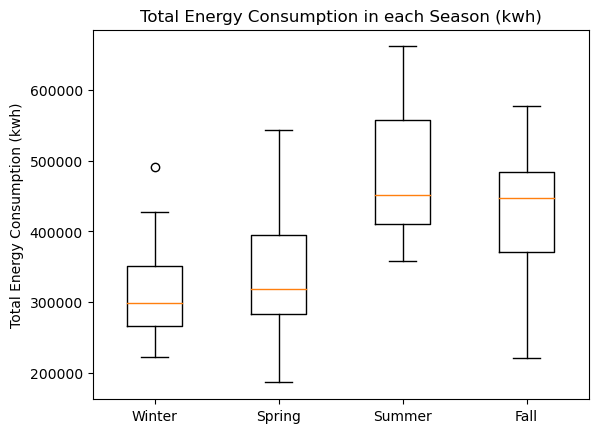

In [50]:
import matplotlib.pyplot as plt
from functions_manage_data import filter_season

SEASON_NAMES = ["Winter", "Spring", "Summer", "Fall"]

season_dfs = []
for season in SEASON_NAMES:
    df = filter_season(season, df_util_temp)
    season_dfs.append(df.reset_index())

season_data = []
for df in season_dfs:
    season_data.append(df["total_consumption"])

plt.boxplot(season_data, labels=SEASON_NAMES)
plt.ylabel("Total Energy Consumption (kwh)")
plt.title("Total Energy Consumption in each Season (kwh)")
plt.show()

The boxplot above shows the ranges and medians of electricity consumption for each of the seasons. As we expected, winter had significantly lower consumption while summer had significantly higher values. This information supports our hypothesis that the high correlation between temperature and electricity consumption was indeed because of how Olin manages its power usage during the winter and summer seasons. 

While the connection between temperature and electricity consumption might be intuitive, the correlation found for average wind speed is not. To explore more into this phenomenon, we graphed `wind speed` against `average temperature`.

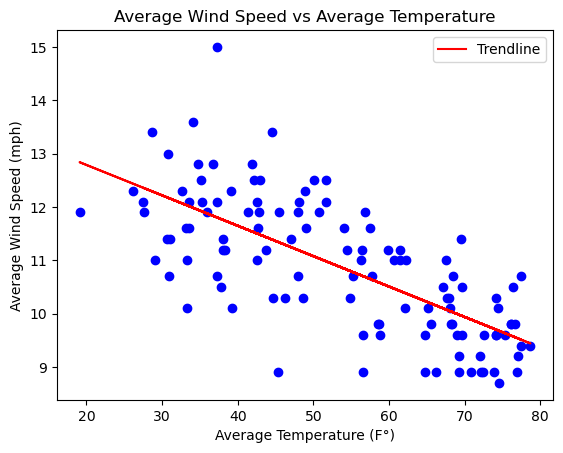

In [51]:
import numpy as np

avg_temp = df_util_temp["value"]
avg_wind = df_util_wind["value"]
plt.scatter(avg_temp, avg_wind, color="blue")
plt.xlabel("Average Temperature (F°)")
plt.ylabel("Average Wind Speed (mph)")
plt.title("Average Wind Speed vs Average Temperature")

z = np.polyfit(avg_temp, avg_wind, 1)
p = np.poly1d(z)
plt.plot(avg_temp, p(avg_temp), color="red", label="Trendline")
plt.legend()
plt.show()

Looking at the graph above, we can see that average wind speed is clearly `negatively correlated` with average temperature, meaning the correlation between wind speed and electricity consumption was mostly likely rooted in temperature differences instead of much to do with wind speed itself.

Lastly, we investigated the rise in consumption in 2016-2017 by looking at enrollment numbers online. There was about a 5.7% increase in enrollment (20 people), but that isn't likely to cause such a significant increase in consumption. 

## Which features are the most important?
We were also curious to see which features were most relevant in our target variable, `Total Cons. (kwh)`. So, we merged all the data we had available -- climate and utility -- to create a single dataframe for analysis. 

In [52]:
from functions_manage_data import merge_all_df

df_all_data = merge_all_df([df_avg_temp, df_avg_wind, df_total_prcp])

Here's what the dataframe looked like after the processing:

In [53]:
display(HTML(df_all_data.head(10).to_html()))

,total_consumption,time_of_peak_demand,total_cost,year-month,TAVG,AWND,PRCP,month
0,337440,14.500000,52000.85,2013-04,48.9,12.3,1.37,4
1,316800,14.916667,50335.03,2013-05,58.8,9.6,3.22,5
2,404640,12.833333,59092.46,2013-06,69.6,10.5,10.50,6
3,424320,12.166667,64701.47,2013-07,77.1,9.2,3.62,7
4,350400,11.250000,49643.51,2013-08,72.1,8.9,1.84,8
5,354720,13.583333,52519.41,2013-09,64.7,8.9,2.22,9
6,338880,13.500000,41734.16,2013-10,56.6,8.9,0.62,10
7,299520,11.166667,39356.74,2013-11,42.7,11.6,2.72,11
8,276960,16.916667,51161.32,2013-12,33.3,10.1,4.63,12
9,259680,14.250000,55521.64,2014-01,27.6,11.9,3.24,1


To analyze which features were the most influential predictors of the total consumption of electricity, we employed the analysis of variance (ANOVA) F-test.

To give a little bit of context, the ANOVA F-test statistic is defined as 
- the ratio of mean square error to regression mean square
    - **mean square error**: the mean of squares of the error between the observed and the predicted value (in our case, generated using linear regression model)
    - **regression mean square**: the mean of squares of difference between the fitted value and the mean of observed values. 

Or alternatively, as
- the ratio of **variation between groups** to **variation within the group**

Another important statistic we obtained was the p-value. The **p-value** is an indicator that if below a certain threshold, ⍺, the result of the statistic is significant. A common value for ⍺ is 0.05. 

A higher F-statistic, combined with a p-value below ⍺, could be interpreted as having greater influence on the target variable.
In our case, the target variable was the total monthly electricity consumption and the features were: 
- monthly total precipitation
- month of year
- time of peak demand
- monthly average wind speed
- monthly average temperature
- total monthly electricity cost

In [54]:
from functions_f_test import feature_selection

## Separating the features and the target
features = df_all_data.drop(columns=["total_consumption", "year-month"])
target = df_all_data["total_consumption"]

df_results = feature_selection(features, target)

Here are the results:

In [55]:
display(HTML(df_results.to_html()))

,Feature,F-Score,p-value
1,total_cost,375.599065,7.106040e-38
2,TAVG,139.601129,1.607382e-21
3,AWND,29.178762,3.654752e-07
0,time_of_peak_demand,7.389142,7.587355e-03
5,month,6.188838,1.430237e-02
4,PRCP,0.061378,8.047770e-01


To visualize the results, we made a bar plot that shows the F-Scores of different features. 

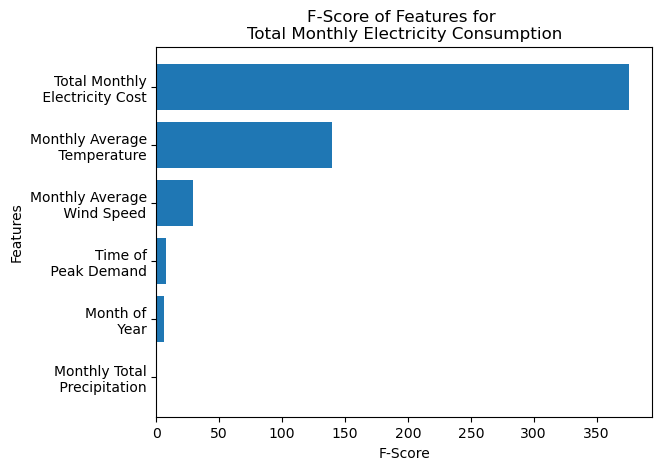

In [56]:
from functions_f_test import plot_f_test

plot_f_test(df_results)